In [1]:
import sys
from pathlib import Path

# Add parent directory to Python path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd

import scvi


/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://

In [2]:
device = 'cpu'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda
NVIDIA L40S


In [3]:
# Use paths relative to the project root (parent directory of this notebook)
DATA_PATH = '/projectnb/czlab/A00/ycliu/Single_cell_public_datasets/BMMC_from12donors_90K/'

OUTPUT_PATH = "../data/outputs/"


# Load dataset

In [7]:
adata = sc.read_h5ad(DATA_PATH + 'GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad')

adata

/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 90261 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Preprocess

/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  return fn(*args_all, **kw)


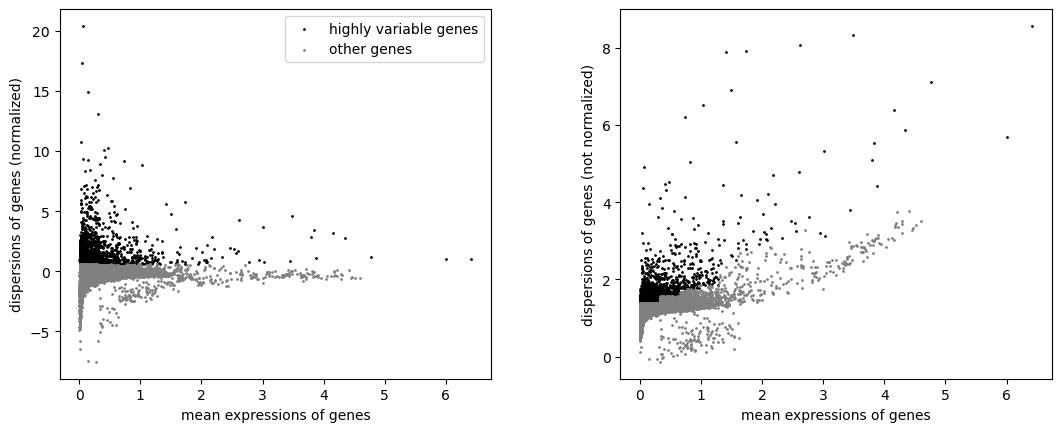

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [9]:
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]
adata

/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


View of AnnData object with n_obs × n_vars = 90261 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dataset_id', 'genome', 'organism', 'log1p', 'hvg'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

# Feature encoder

In [10]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], # Encoder dimension in each layer
                   D_decode_list=[50, 300, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2026-01-01 16:20:09,637 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Private_CellDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2026-01-01 16:20:12,028 - ------------------------> Epoch: 1/2000, Current loss: 54326816.0000
2026-01-01 16:20:18,790 - ------------------------> Epoch: 51/2000, Current loss: 21620914.0000
2026-01-01 16:20:25,517 - ------------------------> Epoch: 101/2000, Current loss: 19832032.0000
2026-01-01 16:20:32,243 - ------------------------> Epoch: 151/2000, Current loss: 18896072.0000
2026-01-01 16:20:38,972 - ------------------------> Epoch: 201/2000, Current loss: 18380240.0000
2026-01-01 16:20:45,796 - ------------------------> Epoch: 251/2000, Current

In [11]:
sc.pp.neighbors(adata, use_rep='X_fae', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


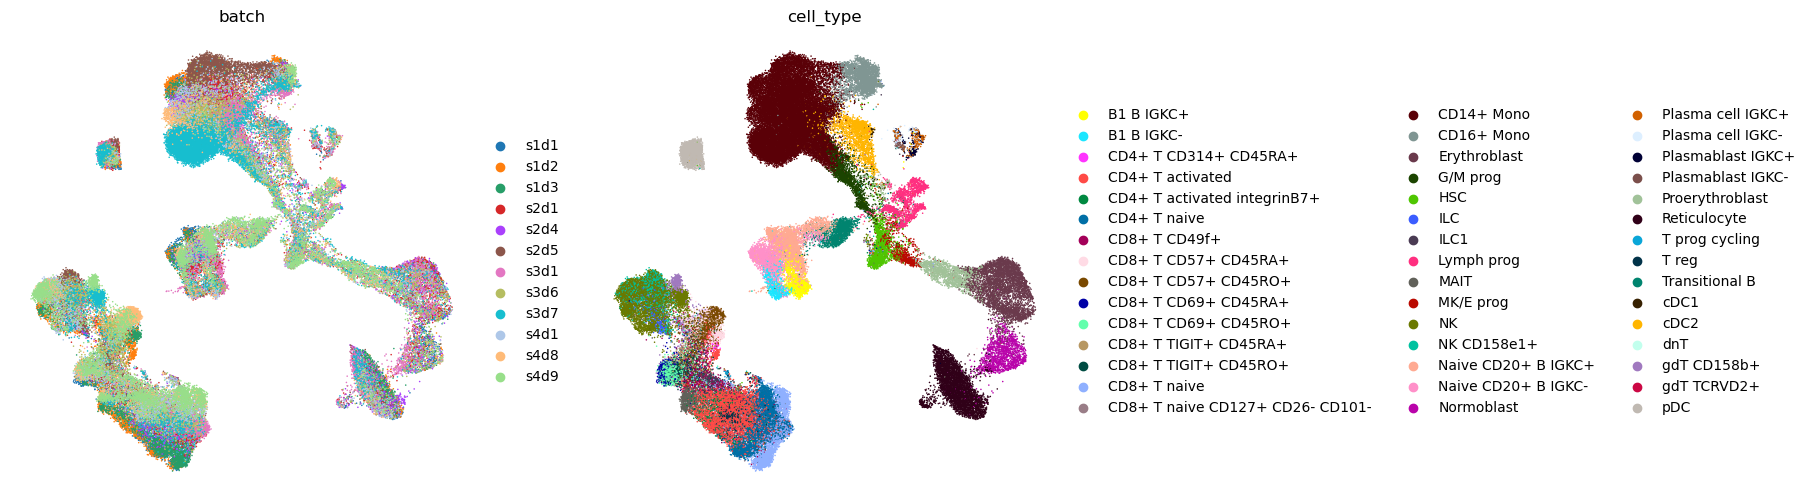

In [6]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'cell_type'], frameon=False, size=5, ncols=2)

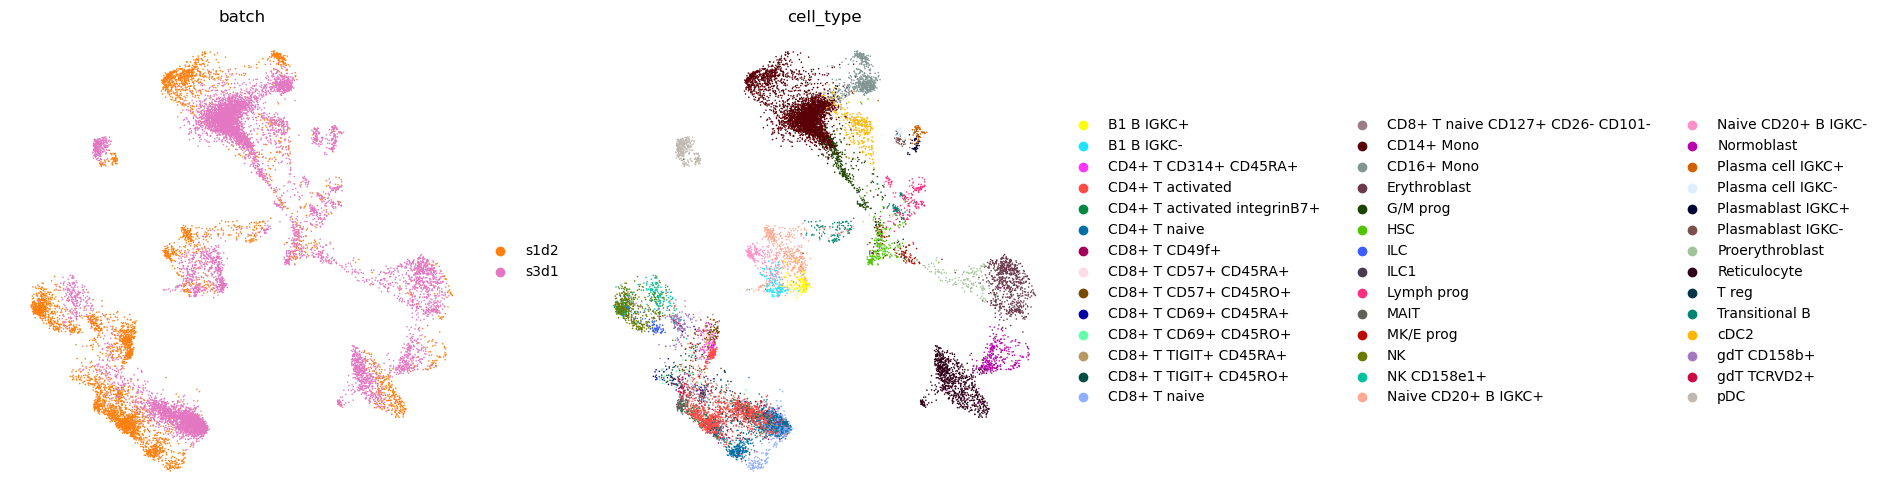

In [8]:
adata_1 = adata[adata.obs['batch'].isin(['s1d2', 's3d1'])]
sc.pl.umap(adata_1, color=['batch', 'cell_type'], frameon=False, size=5, ncols=2)

# Integration

In [10]:
# Build the diffusion graph for data intagration

cd.inte.build_integration_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [11]:
# Build the input KNN adjacencies for each batch, which is used in loss function.

cd.inte.build_integration_loss_adj(adata, 
                                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                   k=50,            # K for building KNN graph
                                   device=device)

In [12]:
cd.inte.integration_diffusion(adata, 
                              use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                              max_epoch=2000,  # The number of training epoch
                              lr=1e-3,         # Learning rate
                              num_features_diffusion=8,
                              num_heads_diffusion=2,
                              num_steps_diffusion=2,
                              time_increment_diffusion=0.5, # Suggested value==0.2 when using 8 diffusion layers.
                              device=device)


2025-12-19 14:51:41,769 - --------> Starting data integration ...
/Users/liuyuchen/Proj/Private_CellDiffusion/sc_integration/integration_DIF.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2025-12-19 14:51:41,996 - ------------------------> Epoch: 1/2000, Current loss: 521179648.0000
2025-12-19 14:51:49,526 - ------------------------> Epoch: 51/2000, Current loss: 27131964.0000
2025-12-19 14:51:57,061 - ------------------------> Epoch: 101/2000, Current loss: 26003582.0000
2025-12-19 14:52:04,503 - ------------------------> Epoch: 151/2000, Current loss: 25941056.0000
2025-12-19 14:52:11,933 - ------------------------> Epoch: 201/2000, Current loss: 25917990.0000
2025-12-19 14:52:19,320 - ------------------------> Epoch: 251/2000, Current lo

## View integrated embeddings

In [13]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=8)
sc.tl.umap(adata)

/Users/liuyuchen/mamba/envs/CellDiffusion_env/lib/python3.11/site-packages/scanpy/neighbors/__init__.py:430: FutureWarning: Use obsm (e.g. `k in adata.obsm` or `adata.obsm.keys() | {'u'}`) instead of AnnData.obsm_keys, AnnData.obsm_keys is deprecated and will be removed in the future.
  if "X_diffmap" in adata.obsm_keys():


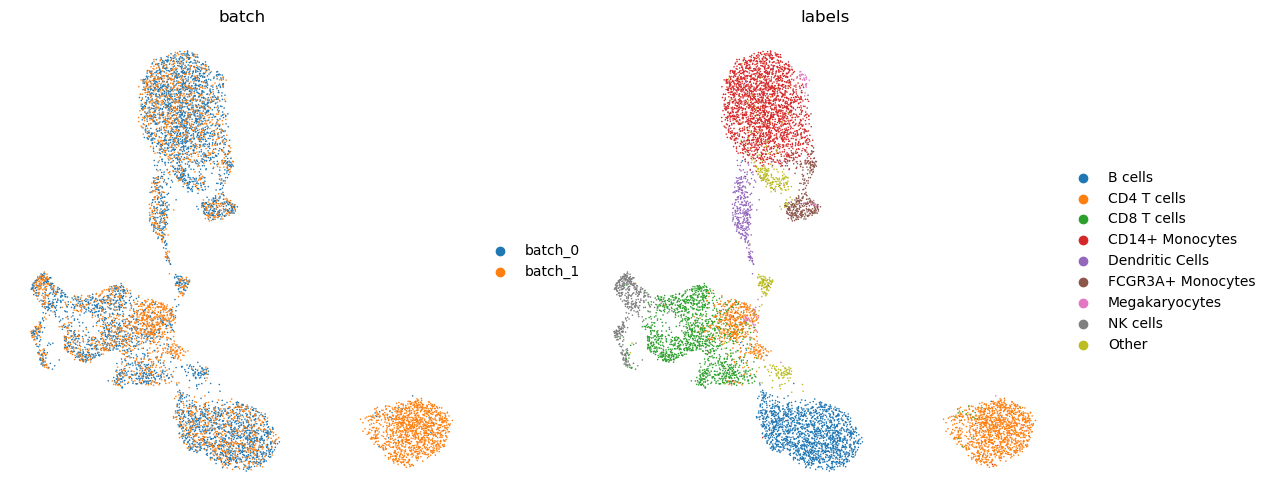

In [14]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'labels'], frameon=False, size=5, ncols=2)

# Save integrated data

In [16]:
adata.write(OUTPUT_PATH + 'scDiffusion_integration.h5ad')

In [4]:
adata = ad.read_h5ad(OUTPUT_PATH + 'scDiffusion_integration.h5ad')
